In [2]:
import torch
import torchvision 
import torchvision.transforms as transforms 
import torchvision.models as models 
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.colors

from collections import OrderedDict

In [12]:
# For the specific case mentioned in the word document, where the true label is 47, the generalist model predicted 52, both specialist models predicted 47, 
# and the ensemble predicted 52. 

generalist_outputs = torch.Tensor([-1.1193, -1.6600, -3.7694, -2.0557, -1.8543, -0.2504, -5.3572, -1.1067,
         2.2015, -2.1315, -2.5698,  1.4911,  4.5909,  3.5433, -3.5992,  5.0107,
        -2.8211,  0.9792, -3.5112,  1.4441,  1.8721, -2.3615, -0.7200, -0.9377,
        -5.0983,  1.8844, -3.0487, -0.9229, -3.9003,  3.6696, -0.2006,  3.8744,
         1.1817,  4.9563, -1.8032,  1.6818, -1.7622,  4.0940,  1.2256, -1.9506,
         1.2746,  0.7632, -0.0823, -4.0094, -2.0969,  1.0753,  0.6781,  9.0300,
         0.2388,  2.1610, -3.5939, -4.6559, 10.0224, -2.2319, -1.1069, -1.1645,
         8.3723, -1.1925,  3.6302,  8.0153,  3.8037, -2.7069,  0.9784, -0.8007,
        -2.5908, -2.9493, -1.0386, -1.7498,  3.4394,  0.2747,  1.2344,  2.0129,
        -0.5599, -1.0684, -2.1036, -0.9118, -0.7197, -2.5336, -2.8716, -1.2953,
        -2.7558,  2.6497,  2.6033,  1.3669, -1.1457,  3.1217, -4.7496,  1.4481,
        -3.9960,  1.8051,  3.2468, -1.1316, -0.1780, -2.6462, -1.2656, -0.9551,
         8.2663, -3.2430, -0.0424, -4.5584])

specialist_outputs = torch.Tensor([1.1287, -1.3506, -1.5560, -0.1841, -1.2736,  3.3701, -1.0825,  3.1824,
         2.1917,  2.1183, -0.0121, -0.4111, -2.5154, -0.6738, -1.8484, -1.5082,
        -1.3254, -1.1942,  2.1274, -1.5033])

specialist_outputs_2 = torch.Tensor([-0.8767, -0.5501, -2.2812, -0.9932,  0.2289,  0.2147,  4.3365, -1.3100,
         3.6750,  3.2303, -0.8859,  1.0791,  0.9822, -0.4972, -1.2536, -1.6154,
        -1.9936, -2.8269, -0.9653, -2.0894,  3.2739, -1.1976])

baseline_class = torch.Tensor([52])
label = torch.Tensor([47])

if torch.cuda.is_available(): 
    generalist_outputs = generalist_outputs.cuda()
    specialist_outputs = specialist_outputs.cuda() 
    specialist_outputs_2 = specialist_outputs_2.cuda()
    baseline_class = baseline_class.cuda() 
    label = label.cuda()

In [26]:
def get_predicted_class_whole(baseline_class, generalist_output, specialist_outputs, sub_classes): 
    
    num_classes = 100 
    q_dist = torch.randn(num_classes, requires_grad = True, device = "cuda:0")

    optimizer = optim.Adam([q_dist], lr = 0.01)
    criterion = nn.KLDivLoss() 
    previous_loss = 10000.0
    loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
    

    num_specialists = len(sub_classes)
    for i in range(num_specialists):
        sub_class = sub_classes[i]
        if baseline_class in sub_class: 
            modified_q_dist = np.zeros(len(sub_class) + 1)
            q_dist_copy = q_dist.clone() 
            for index in range(len(sub_class)): 
                modified_q_dist[index] = q_dist_copy[sub_class[index]]
                q_dist_copy[sub_class[index]] = 0.0 
                
            modified_q_dist[len(sub_class)] = torch.sum(q_dist_copy)
            modified_q_dist = torch.tensor(modified_q_dist)
            if torch.cuda.is_available(): 
                modified_q_dist = modified_q_dist.cuda()
                
            loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_outputs[i]))
            
        
    niter = 0
    history = OrderedDict()
    loss_dict = OrderedDict()
    
    #while loss > 1e-3: 
    while previous_loss > loss and loss > 1e-3: 
        previous_loss = loss 
        loss.backward(retain_graph = True)
        optimizer.step()
        optimizer.zero_grad()
        loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
        
        for i in range(num_specialists): 
            sub_class = sub_classes[i]
            if baseline_class in sub_class: 
                modified_q_dist = np.zeros(len(sub_class) + 1)
                q_dist_copy = q_dist.clone() 
                for index in range(len(sub_class)): 
                    modified_q_dist[index] = q_dist_copy[sub_class[index]]
                    q_dist_copy[sub_class[index]] = 0.0 
                    
                modified_q_dist[len(sub_class)] = torch.sum(q_dist_copy)
                modified_q_dist = torch.tensor(modified_q_dist)
                if torch.cuda.is_available(): 
                    modified_q_dist = modified_q_dist.cuda()
                    
                loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_outputs[i]))
        
        niter+=1
        loss_dict[niter] = dict(predicted = torch.max(q_dist.data, 0), loss = loss.detach().clone())
        if niter % 50 == 0:
            #print("i: {:>4}, loss: {:.7f}".format(niter, loss))
            history[niter]=dict(logit=q_dist.detach().clone(), loss=loss.detach().clone())
            
    _, predicted = torch.max(q_dist.data, 0)
    return predicted, q_dist, history, loss_dict


def replicate_specialist(num_copies, baseline_class, generalist_output, specialist_outputs, sub_classes):
    
    specialist_outputs_replicate = []
    sub_classes_replicate = []
    num_specialists = len(sub_classes)
    for i in range(num_specialists): 
        for copy in range(num_copies): 
            specialist_outputs_replicate.append(specialist_outputs[i])
            sub_classes_replicate.append(sub_classes[i])
    
    predicted, q_dist, history, loss_dict = get_predicted_class_whole(baseline_class, generalist_output, specialist_outputs_replicate, sub_classes_replicate)
    
    return specialist_outputs_replicate, sub_classes_replicate, predicted, q_dist, history, loss_dict

def plot_iteration_history(q_history): 
    
    ncol = 4
    nrow = len(history)//ncol
    if len(history) % ncol > 0: 
        nrow += 1 
    
    fig, axes = plt.subplots(nrows = nrow, ncols = ncol, figsize = (ncol*6, nrow*3))
    plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.4, hspace = 0.4)
    
    for i, (niter, history_dict) in enumerate(q_history.items()): 
        loss = history_dict['loss']
        q_logit = history_dict['logit']
            
        r=i//ncol
        c=i%ncol
    
        if len(history) > 4: 
            axes[r, c].bar(np.arange(q_logit.shape[0]), softmax(q_logit.detach().cpu().numpy()))
            axes[r, c].set_title("iter #{}, loss={:0.5f}".format(niter, loss))
        else: 
            axes[c].bar(np.arange(q_logit.shape[0]), softmax(q_logit.detach().cpu().numpy()))
            axes[c].set_title("iter #{}, loss={:0.5f}".format(niter, loss))            
    
    return fig 


def compare_q_plots(q_history, baseline_pred, generalist_output, specialist_outputs, sub_classes):
    
    num_classes = 100 
    num_specialists = len(sub_classes)
    
    generalist_output = generalist_output.detach().cpu().numpy()
    
    s_dists = [] 
    s_dists.append(generalist_output)
    for i in range(num_specialists): 
        sub_class = sub_classes[i]
        s_dist = np.zeros(num_classes)
        s_out = specialist_outputs[i]
        s_out = s_out.detach().cpu().numpy()
        for j in range(len(sub_class) - 1): 
            s_dist[sub_class[j]] = s_out[j]
            
        s_dists.append(s_dist)
                      
    nrow = 1
    ncol = 1 + num_specialists
    
    fig, axes = plt.subplots(nrows = nrow, ncols = ncol)
    fig.set_size_inches(25, 5)
    
    subtitle = ['Generalist dist']
    for i in range(ncol): 
        dist = s_dists[i]
        axes[i].bar(np.arange(dist.shape[0]), softmax(dist), color = 'green')
        if i == 0: 
            title = 'Generalist dict'
            axes[i].set_title(title)
        else: 
            title = 'Specialist' + " " + str(i) + " " + 'dict'
            axes[i].set_title(title)
        
    return fig  


def get_loss_plot_and_top_1_pred(loss_dict):   
    loss_values = [] 
    predicted_values = [] 

    for i, (niter, loss_hist) in enumerate(loss_dict.items()): 
        loss = loss_hist['loss']
        prediction = loss_hist['predicted']
        _, predicted_class = prediction 
    
        loss_values.append(loss.detach().cpu())
        predicted_values.append(predicted_class.detach().cpu())
    
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2)
    fig.set_size_inches(10, 5)
    axes[0].plot(np.arange(len(loss_values)), loss_values)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    
    axes[1].plot(np.arange(len(predicted_values)), predicted_values)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Predicted class')
    return fig


def softmax(x, T=1):
    return np.exp(x/T)/sum(np.exp(x/T))

In [28]:
def get_predicted_class_whole_modified(baseline_class, generalist_output, specialist_outputs, sub_classes): 
    
    num_classes = 100 
    q_dist = torch.randn(num_classes, requires_grad = True, device = "cuda:0")

    optimizer = optim.Adam([q_dist], lr = 0.01)
    criterion = nn.KLDivLoss() 
    previous_loss = 10000.0
    loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
    

    num_specialists = len(sub_classes)
    for i in range(num_specialists):
        sub_class = sub_classes[i]
        if baseline_class in sub_class: 
            modified_q_dist = np.zeros(len(sub_class) + 1)
            q_dist_copy = q_dist.clone() 
            for index in range(len(sub_class)): 
                modified_q_dist[index] = q_dist_copy[sub_class[index]]
                q_dist_copy[sub_class[index]] = 0.0 
                
            modified_q_dist[len(sub_class)] = torch.sum(q_dist_copy)
            modified_q_dist = torch.tensor(modified_q_dist)
            if torch.cuda.is_available(): 
                modified_q_dist = modified_q_dist.cuda()
                
            loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_outputs[i]))
            
        
    niter = 0
    history = OrderedDict()
    loss_dict = OrderedDict()
    
    #while loss > 1e-3: 
    for epoch in range(500): 
    #while previous_loss > loss and loss > 1e-3: 
        previous_loss = loss 
        loss.backward(retain_graph = True)
        optimizer.step()
        optimizer.zero_grad()
        loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
        
        for i in range(num_specialists): 
            sub_class = sub_classes[i]
            if baseline_class in sub_class: 
                modified_q_dist = np.zeros(len(sub_class) + 1)
                q_dist_copy = q_dist.clone() 
                for index in range(len(sub_class)): 
                    modified_q_dist[index] = q_dist_copy[sub_class[index]]
                    q_dist_copy[sub_class[index]] = 0.0 
                    
                modified_q_dist[len(sub_class)] = torch.sum(q_dist_copy)
                modified_q_dist = torch.tensor(modified_q_dist)
                if torch.cuda.is_available(): 
                    modified_q_dist = modified_q_dist.cuda()
                    
                loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_outputs[i]))
        
        niter+=1
        loss_dict[niter] = dict(predicted = torch.max(q_dist.data, 0), loss = loss.detach().clone())
        if niter % 50 == 0:
            #print("i: {:>4}, loss: {:.7f}".format(niter, loss))
            history[niter]=dict(logit=q_dist.detach().clone(), loss=loss.detach().clone())
            
    _, predicted = torch.max(q_dist.data, 0)
    return predicted, q_dist, history, loss_dict


def replicate_specialist_modified(num_copies, baseline_class, generalist_output, specialist_outputs, sub_classes):
    
    specialist_outputs_replicate = []
    sub_classes_replicate = []
    num_specialists = len(sub_classes)
    for i in range(num_specialists): 
        for copy in range(num_copies): 
            specialist_outputs_replicate.append(specialist_outputs[i])
            sub_classes_replicate.append(sub_classes[i])
    
    predicted, q_dist, history, loss_dict = get_predicted_class_whole_modified(baseline_class, generalist_output, specialist_outputs_replicate, sub_classes_replicate)
    
    return specialist_outputs_replicate, sub_classes_replicate, predicted, q_dist, history, loss_dict

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/o

True label: tensor([47.], device='cuda:0'), Ensemble prediction: 47


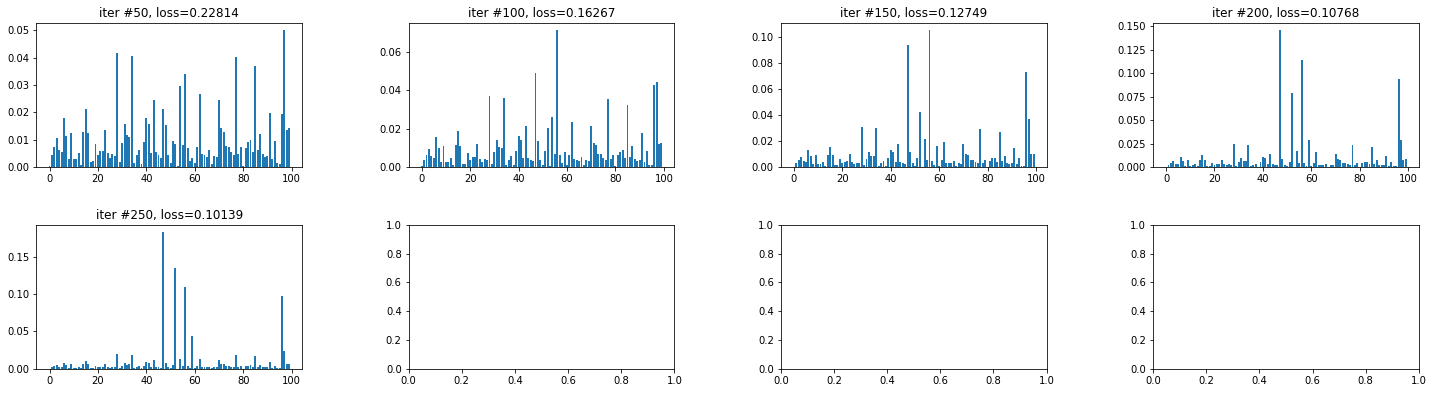

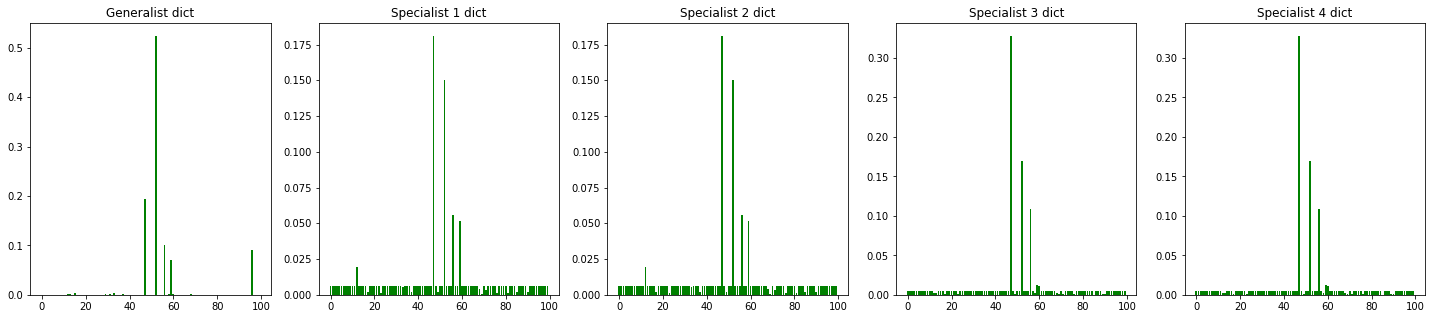

In [24]:
specialist_outputs_array = [] 
specialist_outputs_array.append(specialist_outputs)
specialist_outputs_array.append(specialist_outputs_2)
sub_classes = [[12, 17, 23, 33, 37, 47, 49, 52, 56, 59, 60, 68, 69, 71, 76, 81, 85, 90, 96], 
             [12, 13, 17, 23, 33, 37, 47, 49, 52, 56, 58, 59, 60, 68, 69, 71, 76, 85, 89, 90, 96]]
specialist_outputs_replicate, sub_classes_replicate, ensemble_predicted, q_dist, history, loss_dict = replicate_specialist(num_copies = 2, baseline_class = baseline_class, generalist_output = generalist_outputs,
                                                                     specialist_outputs = specialist_outputs_array, sub_classes = sub_classes)
print("True label: {}, Ensemble prediction: {}".format(label, ensemble_predicted))
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, baseline_class, generalist_outputs, specialist_outputs_replicate, sub_classes_replicate)

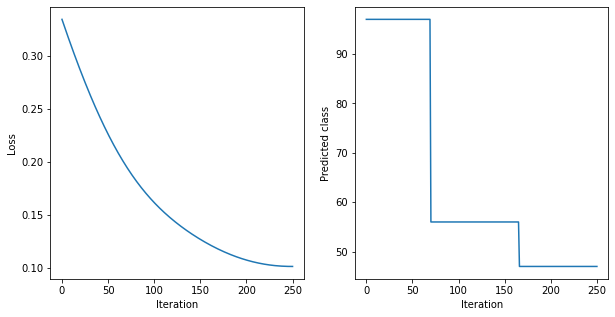

In [27]:
# If we look at the loss plot and top 1 predicted class 
loss_fig = get_loss_plot_and_top_1_pred(loss_dict)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/o

True label: tensor([47.], device='cuda:0'), Ensemble prediction: 52


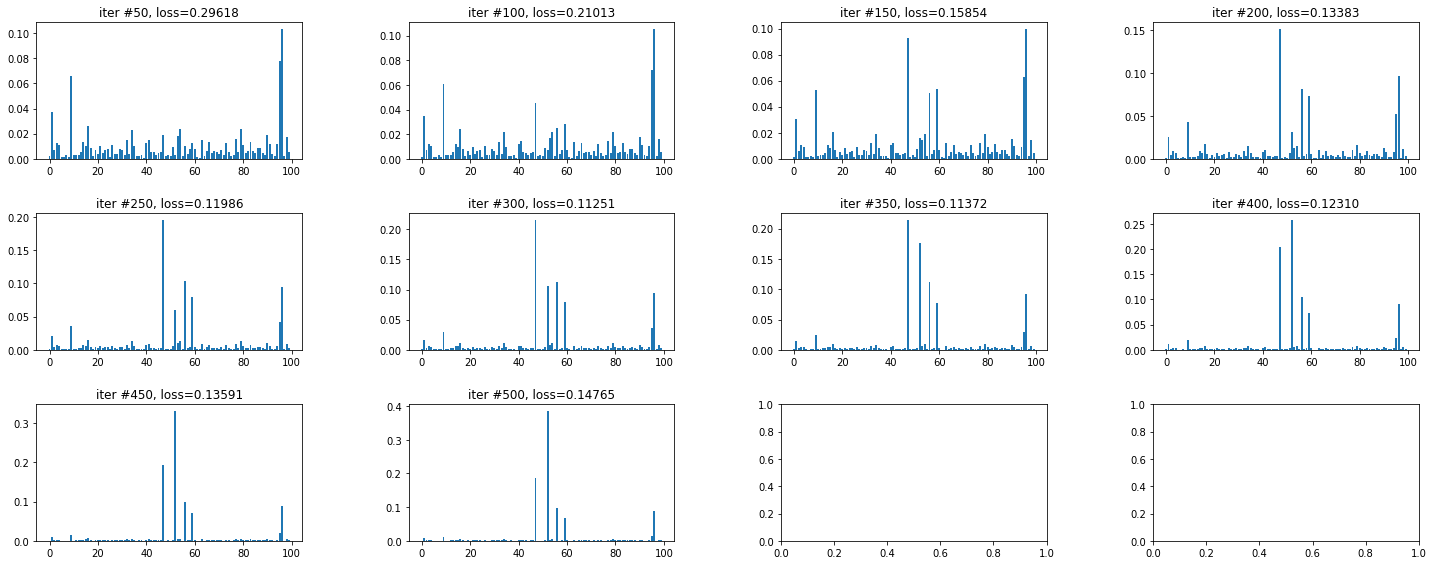

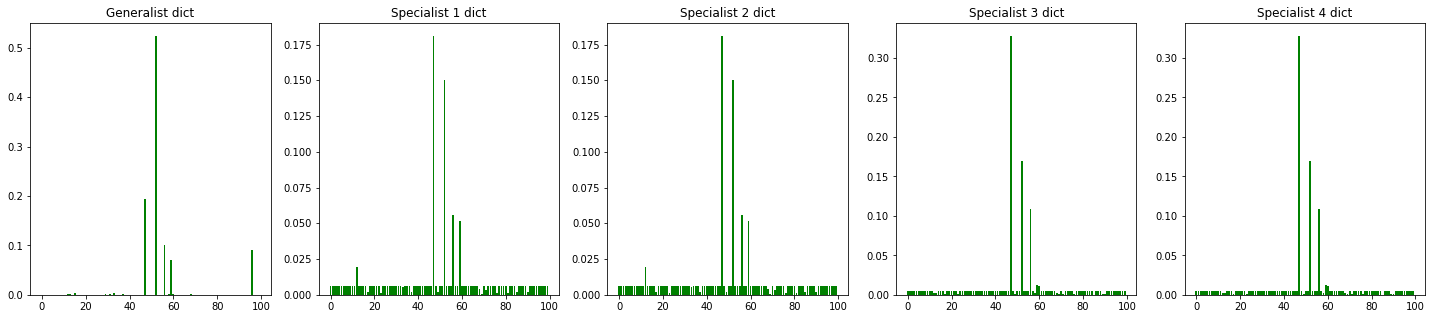

In [31]:
# What if we change the stopping criteria (i.e., allow the loss to diverge and run more iterations)? 
specialist_outputs_replicate, sub_classes_replicate, ensemble_predicted, q_dist, history, loss_dict = replicate_specialist_modified(num_copies = 2, baseline_class = baseline_class, generalist_output = generalist_outputs,
                                                                     specialist_outputs = specialist_outputs_array, sub_classes = sub_classes)
print("True label: {}, Ensemble prediction: {}".format(label, ensemble_predicted))
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, baseline_class, generalist_outputs, specialist_outputs_replicate, sub_classes_replicate)

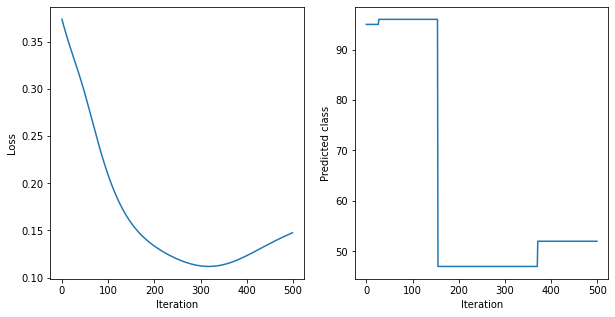

In [32]:
loss_fig = get_loss_plot_and_top_1_pred(loss_dict)
# The ensemble made the wrong prediction after when the loss started to diverge (?)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/o

True label: tensor([47.], device='cuda:0'), Ensemble prediction: 47


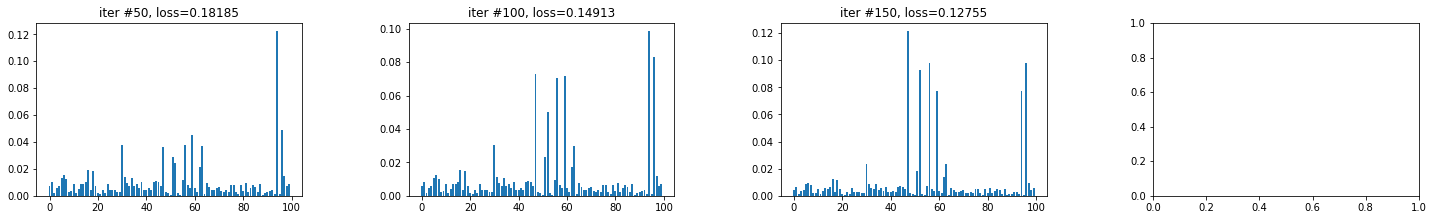

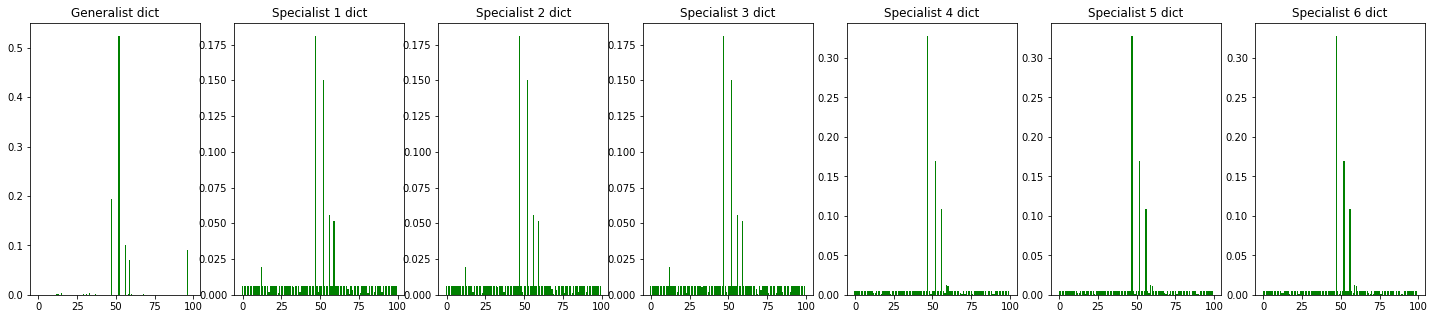

In [34]:
# Notice that the probability of the predicted class of the ensemble is very low (i.e., <0.2). 
# Would this value increase if we add more specialists? 
specialist_outputs_replicate, sub_classes_replicate, ensemble_predicted, q_dist, history, loss_dict = replicate_specialist(num_copies = 3, baseline_class = baseline_class, generalist_output = generalist_outputs,
                                                                     specialist_outputs = specialist_outputs_array, sub_classes = sub_classes)
print("True label: {}, Ensemble prediction: {}".format(label, ensemble_predicted))
q_fig = plot_iteration_history(history)
all_plots = compare_q_plots(history, baseline_class, generalist_outputs, specialist_outputs_replicate, sub_classes_replicate)

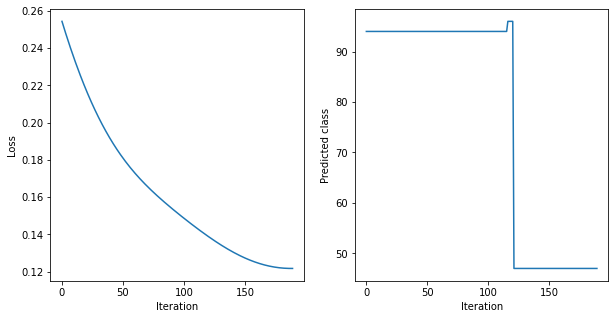

In [35]:
# Nope. The probability value for the predicted class did not increase even if we added more specialists
loss_fig = get_loss_plot_and_top_1_pred(loss_dict)